In [2]:
using Pkg
Pkg.DEFAULT_IO[] = stdout  # Julia 1.6.1 bug (Pkg.jl#2542)
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating environment at `~/Julia/doc/cscs_gpu_course/Project.toml`


In [3]:
using CUDA
CUDA.allowscalar(false)

# Concurrent (GPU) computing

Also known as asynchronous programming, this is a programming model that makes it possible to **perform operations when you wait for another operation to complete, without needing multiple threads**. Julia has great support for this using Tasks:

In [4]:
@sync begin
    @async begin
        println("task 1: operation that waits")
        sleep(0.1)
        println("task 1: done!")
    end
    
    @async println("task 2: another operation")
end;

task 1: operation that waits
task 2: another operation
task 1: done!


This relies on the call to `sleep` not actually blocking, but instead yielding to Julia's scheduler so that other tasks get a chance to execute. Essentially, what it does:

In [5]:
@sync begin
    @async begin
        println("task 1: operation that waits")
        t0 = time()
        while time() - t0 < 0.1
            yield()
        end
        println("task 1: done!")
    end
    
    @async println("task 2: another operation")
end;

task 1: operation that waits
task 2: another operation
task 1: done!


## Concurrent GPU computing

With CUDA, many operations are already "properly asynchronous", meaning they don't only refrain from blocking, but they actually return immediately control back to the user. That useful, because it makes it possible to quickly queue a bunch of operations and (hopefully) saturate the GPU:

```
for i in 1:10
    @cuda kernel(...)
end
```

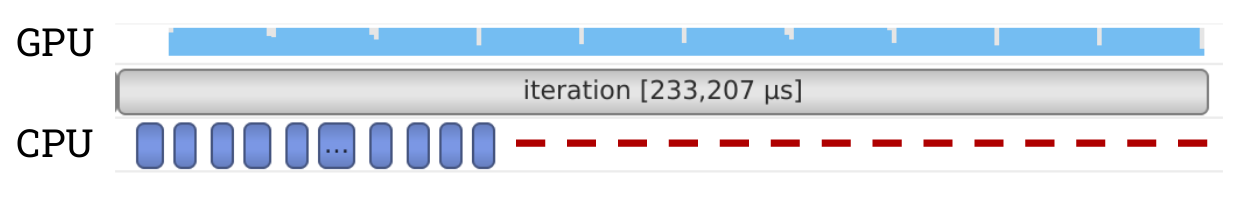

If GPU operations always were synchronous, the GPU would be idle when the CPU is launching a new operation:

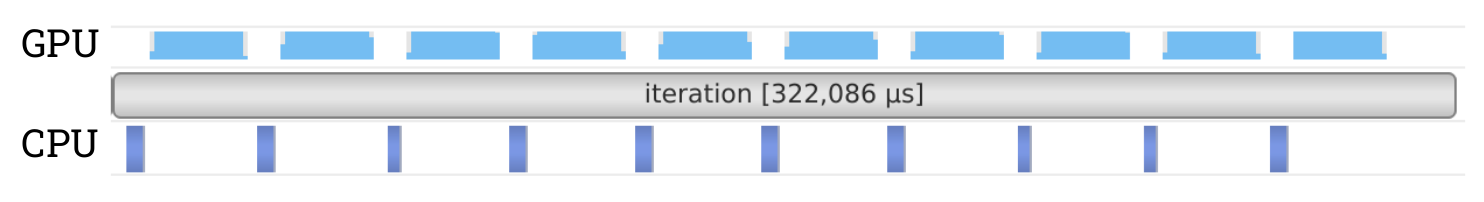

However, there are still some blocking operations, e.g., when you need to wait for the GPU to finish its computations because you want to use those results. In CUDA.jl 3.0, many of those operations ([synchronization](https://github.com/JuliaGPU/CUDA.jl/blob/1c6752c2d65c84d1d0060ceebafab9dbc1c71e15/lib/cudadrv/stream.jl#L120-L149), [memory copying](https://github.com/JuliaGPU/CUDA.jl/blob/1c6752c2d65c84d1d0060ceebafab9dbc1c71e15/src/array.jl#L402-L420), etc) have been changed to similarly block by yielding to the scheduler instead, making it possible to execute other tasks while waiting for the GPU to finish computing:

In [7]:
@sync begin
    @async begin
        println("task 1: submit GPU operations")
        A = CUDA.rand(1024, 1024)
        B = CUDA.rand(1024, 1024)
        A*B
        println("task 1: wait for GPU results")
        synchronize()
        println("task 1: done")
    end
    @async println("task 2: another operation")
end;

task 1: submit GPU operations
task 1: wait for GPU results
task 2: another operation
task 1: done


## Pitfall: blocking GPU operations

I mentioned that CUDA.jl makes *many* of the blocking operations yield to the Julia scheduler, which implies there are some blocking operations left. One common such operation is copying memory to or from the CPU. For example:

In [ ]:
# allocate some memory
a = rand(1024, 1024)

# upload to the GPU
b = CuArray(a);

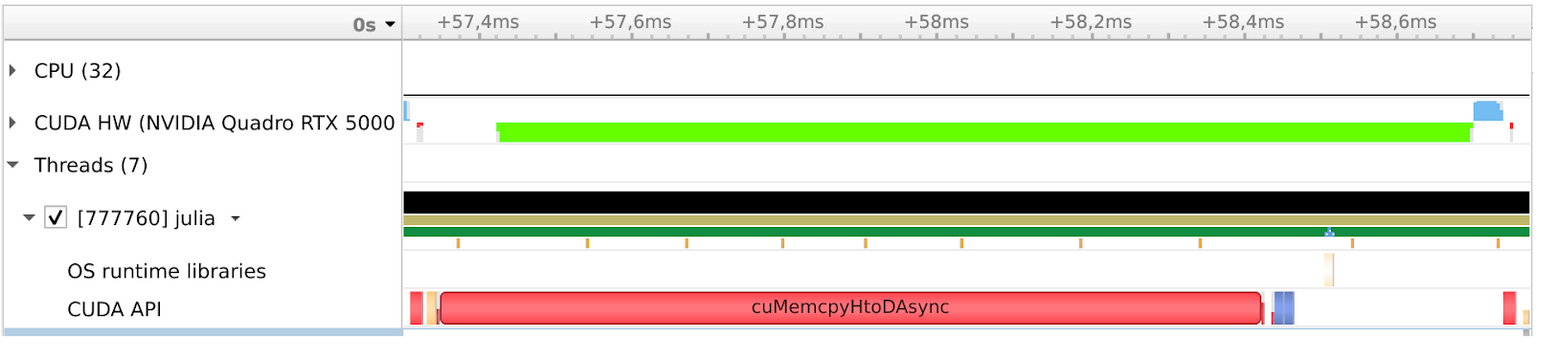

Despite CUDA.jl using an asynchronous version of the API, the call blocked for most of the time it took to complete on the GPU. The reason here is that the CPU memory can be paged out by the operating system at any time, making it impossible for CUDA to perform this operation using an asynchronous memory transfer. Instead the library copies the memory to a staging buffer on the CPU which takes a lot of time.

The solution here is to make sure the memory cannot be paged out by the operating system, by either:
- allocating page-locked memory using CUDA.jl's `Mem.alloc(Mem.HostBuffer, ...)`
- pinning memory after the fact

The latter is much easier:

In [8]:
# allocate & pin some memory
a = rand(1024, 1024)
Mem.pin(a)

# upload to the GPU
b = CuArray(a);

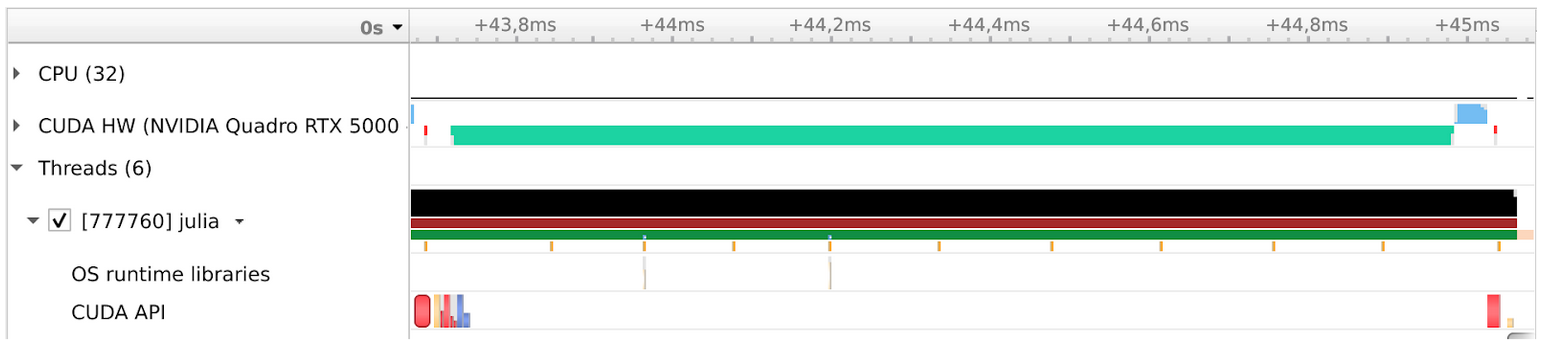

This not only avoids blocking the CPU, but may also speed up the operation by avoiding the copy to a staging buffer.

There is no free lunch, of course:

- pinning memory is expensive, so make sure to pre-allocate and pin the necessary buffers beforehand
- pinning too much memory will reduce overall system performance

## Use case: overlap CPU with GPU operations

Because of the above, it's possible to use the GPU and CPU at the same time by wrapping both computations in separate tasks. However, there's a a problem: most compute-intensive operations don't cause task switches:

In [10]:
@sync begin
    @async begin
        println("CPU task: begin")
        for x in 1:10
            A = rand(1024 * 1024)
            sort(A)
        end
        println("CPU task: end")
    end
    @async begin
        println("GPU task: begin")
        A = CUDA.rand(1024, 1024)
        B = CUDA.rand(1024, 1024)
        A*B
        println("GPU task: wait")
        synchronize()
        println("GPU task: end")
    end
end;

CPU task: begin
GPU task: begin
GPU task: wait
GPU task: end
CPU task: end


Because none of the CPU task's operations are blocking, they never yield, and the GPU task only runs at the end of it all. Blocking operations include:
- input/output: filesystem operations, printing, ...
- synchronization primitives: lcoks, conditions, ...
- channels

Alternatively, as a workaround for compute-intensive tasks that never yield, one could periodically call `yield()`.

## Task-local state

A better alternative is to use multiple tasks for independent GPU operations. However, that requires changes to the GPU programming model, because:

- CUDA uses a per-thread state, such as the active device
- CUDA.jl uses the default stream for all operations

Starting with CUDA.jl 3.0, there are two changes that make it possible to use multiple tasks for independent GPU operations:

- GPU state (active device, library handles, streams) is now task-local instead of thread-local
- all operations (kernel launches, API calls) default to using these task-local values

These properties can be trivially observed:

In [11]:
stream()

CuStream(0x0000000025fd2e20, CuContext(0x00000000051715c0, instance 3d44f89437e87025))

In [12]:
fetch(@async stream())

CuStream(0x00000000263d2730, CuContext(0x00000000051715c0, instance 3d44f89437e87025))

In [13]:
function get_cublas_stream()
    handle = CUBLAS.handle()
    stream = Ref{CUDA.CUstream}()
    CUBLAS.cublasGetStream_v2(handle, stream)
    stream[]
end
get_cublas_stream()

Ptr{Nothing} @0x0000000025fd2e20

In [14]:
fetch(@async get_cublas_stream())

Ptr{Nothing} @0x0000000025f3ab40

Of course, these changes to the programming model have important consequences.

### Pitfalls

One obvious result of this change is that GPU operations are task-local.

In [19]:
A = CUDA.rand(10000, 10000)
B = CUDA.rand(10000, 10000)
A*B

wait(@async synchronize())

CUDA.isdone(stream())

false

You could work around this by calling `device_synchronize()` instead, but it is generally better to synchronize where it's needed.

A not-so-obvious consequence is how data cannot be safely reused across tasks without additional synchronization. Let's illustrate by generating some random matrices and multiplying them in a child task:

In [21]:
A = CUDA.rand(10000, 10000)
B = CUDA.rand(10000, 10000)

C = fetch(
    @async begin
        A*B
    end
)

Array(C) ≈ Array(A)*Array(B) # depending on your system, this may be false

false

There are two issues here, both stemming from the fact that some operations might take a while to complete, but their API calls behave asynchronously and return immediately. This isn't normally a problem because depentend operations are generally issued on the same stream, imposing an ordering.

When using multiple tasks, each with their own stream, there is no such ordering! The application should either impose such an ordering by itself, or wait for the operations to complete.

The first option is the simplest one: by adding calls to `synchronize()` in the tasks that produce data, the application will wait for the operation to complet and the data to be ready. Here, that means adding synchronization at two points!

In [22]:
A = CUDA.rand(10000, 10000)
B = CUDA.rand(10000, 10000)
synchronize()

C = fetch(
    @async begin
        CUDA.@sync A*B
    end
)

Array(C) ≈ Array(A)*Array(B)

true

`CUDA.@sync` is equivalent to a call to `synchronize()`, but preserves the returned value.

Note that again, we used `synchronize()` within the task that produces the data. If that is not possible, you can use `device_synchronize()` before *using* the data, but as said before that is a much more expensive call.

The alternative is to use CUDA events to impose a stream ordering:

In [24]:
input_ready, output_ready = CuEvent(), CuEvent()
A = CUDA.rand(10000, 10000)
B = CUDA.rand(10000, 10000)
record(input_ready)

C = fetch(
    @async begin
        CUDA.wait(input_ready)
        C = A*B
        record(output_ready)
        C
    end
)

synchronize(output_ready)
Array(C) ≈ Array(A)*Array(B)

true

This is better because it only serializes execution once, and thus more operations can be queued up asynchronously, but requires more work on the application side.

## Use case: overlap GPU operations

With all that out of the way, let's look at a much more interesting use case. With modern GPUs becoming more and more powerful, it's getting harder to:

- saturate the entire device using a single stream of operations;
- have every kernel use all of the device's hardware resources.

One solution to this problem is using multiple streams of operations so that the GPU can overlap operations whenever possible. With CUDA.jl this is as simple as putting indepent work in separate Julia tasks:

```
function compute(a,b,c)
   mul!(c, a, b)
   broadcast!(sin, c, c)
   synchronize()
   c
end

@async compute(...)
@async compute(...)
```

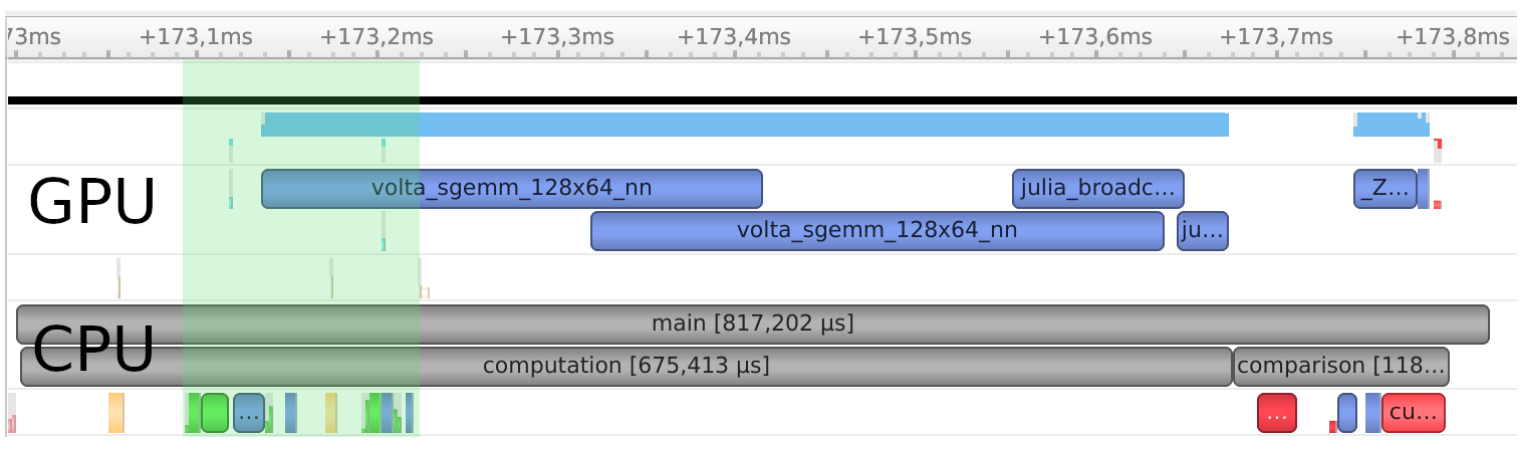

Let's apply this to the RMSE calculation from a previous notebook. Recall the original implementation:

In [27]:
N = 16
A = CUDA.rand(1024, 1024, N)
B = CUDA.rand(1024, 1024, N)
CUDA.allowscalar(false)

rmse(A, B) = sqrt(sum((A-B).^2)/length(A))

rmses = Vector{eltype(A)}(undef, N)
for i in 1:N
    rmses[i] = rmse(A[:, :, i], B[:, :, i])
end
rmses

16-element Vector{Float32}:
 0.4082115
 0.40827584
 0.40855086
 0.4083253
 0.408295
 0.40889436
 0.40822
 0.4088785
 0.40833458
 0.40843233
 0.40848547
 0.40807292
 0.40823755
 0.40833881
 0.40831104
 0.40839547

Performing this computation in multiple tasks is easy enough:

In [28]:
rmses = Vector(undef, N)
synchronize()
for i in 1:N
    rmses[i] = @async rmse(A[:, :, i], B[:, :, i])
end
fetch.(rmses)

16-element Vector{Float32}:
 0.4082115
 0.40827584
 0.40855086
 0.4083253
 0.408295
 0.40889436
 0.40822
 0.4088785
 0.40833458
 0.40843233
 0.40848547
 0.40807292
 0.40823755
 0.40833881
 0.40831104
 0.40839547

We don't need to synchronize after the execution of `rmse`, because the function returns a scalar and thus is synchronizing on itself.

In the profiler, we can see that some kernels executed together:

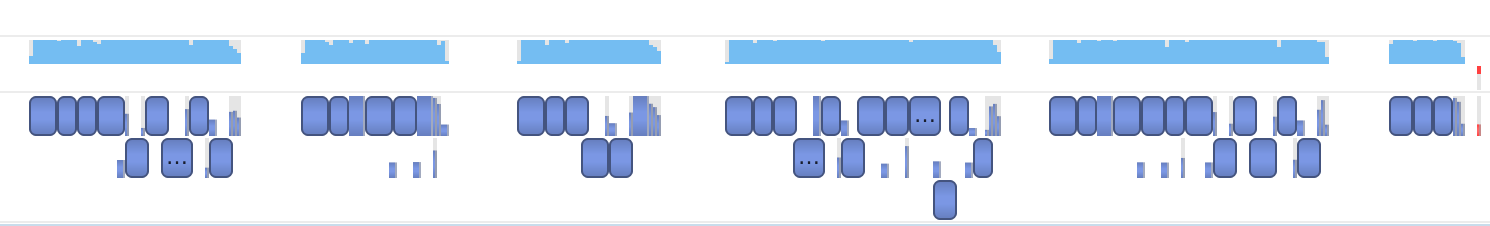

Zoomed in:

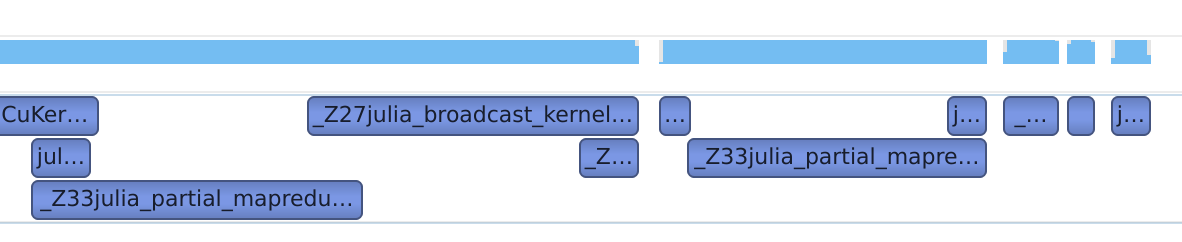

For such a simple operation this doesn't help, but it nicely demonstrates the API and how the GPU executes kernels in parallel.

## Use case: multi-GPU applications

Because the active device is a task-local property too, and CUDA.jl automatically switches contexts when performing API calls after a task switch, tasks can be used for using multiple GPUs within a single process:

In [29]:
@sync begin
    @async begin
        device!(0)
        @cuda identity(nothing)
    end
    @async begin
        device!(1)
        @cuda identity(nothing)
    end
end;

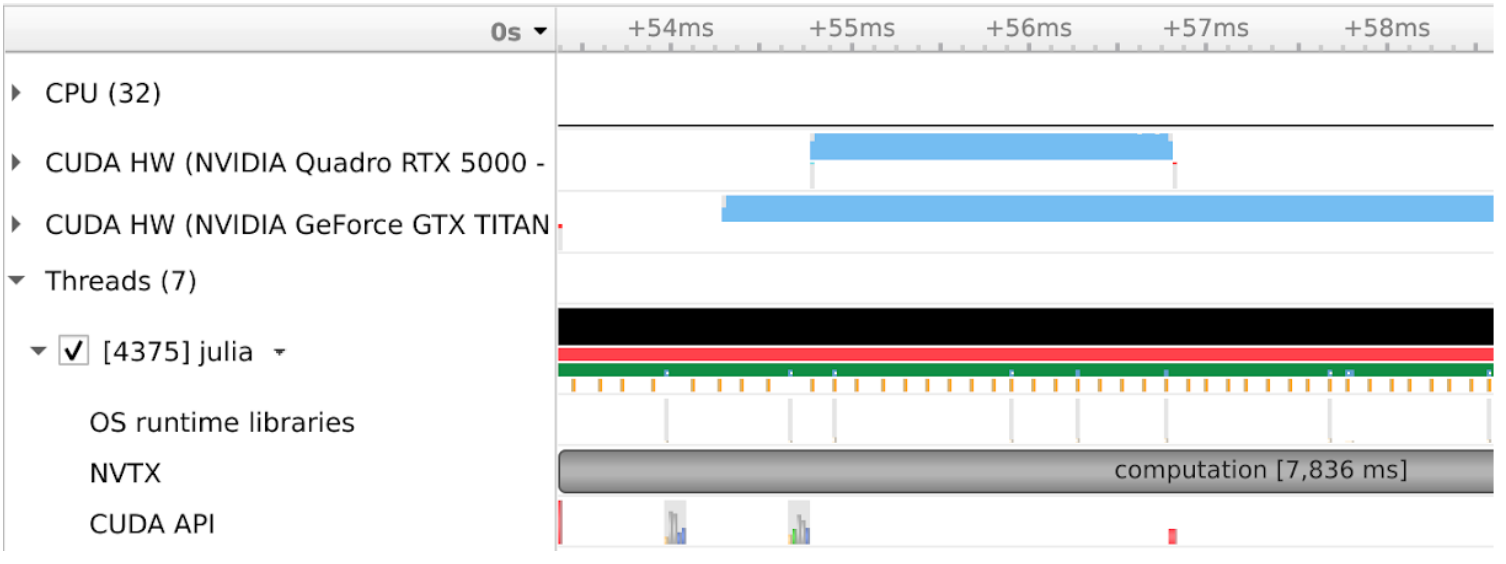

There are currently still some sharp edges:
- tasks should pick a device (`device!`) at the start
- arrays do not track which device they were owned by

Especially the second point is important, because using another device's memory will result in illegal memory access errors. One workaround for now is to use unified memory via `CuArray{..., Mem.UnifiedBuffer}(...)` or `cu(...; unified=true)`.

## Use case: multithreading

Finally, it's also possible to use multiple threads using Julia's `@spawn` macro. For example, combining with the previous example:

In [ ]:
@sync begin
    Threads.@spawn begin
        device!(0)
        @cuda identity(nothing)
    end
    Threads.@spawn begin
        device!(1)
        @cuda identity(nothing)
    end
end;

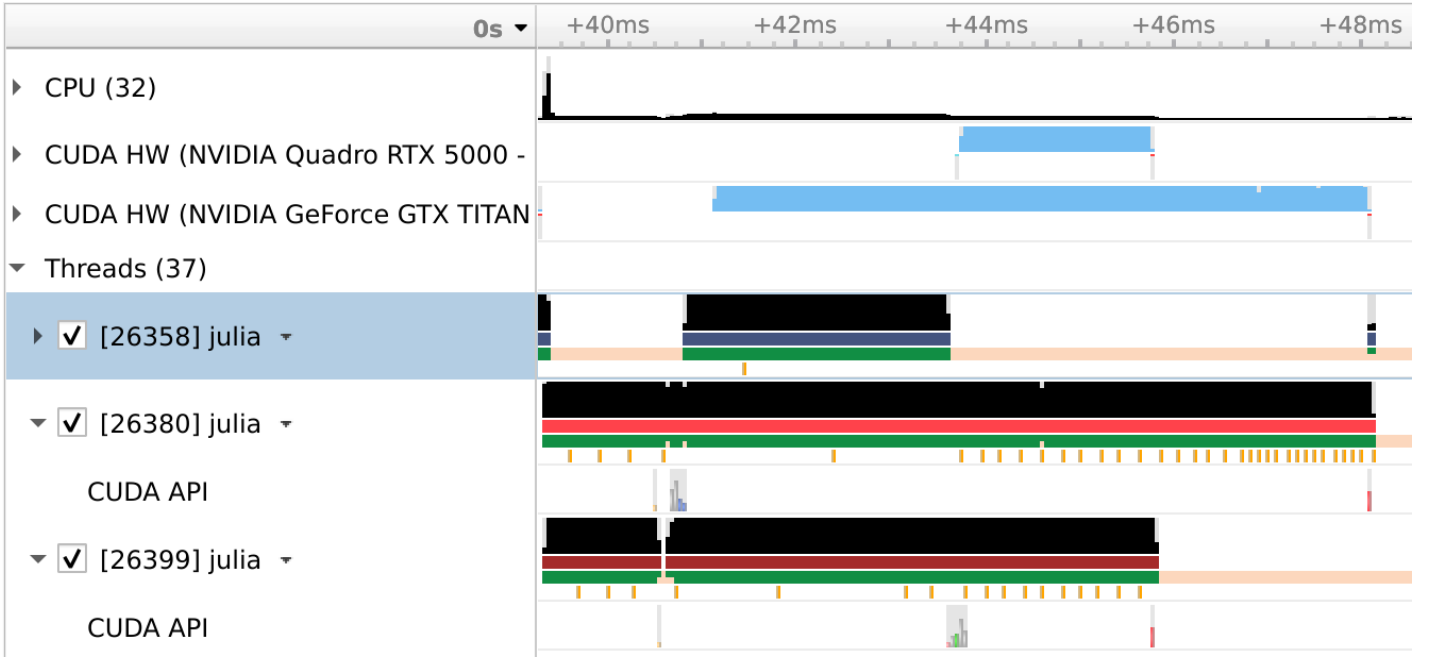

Although thread-safety is a work in progress, so you might run into crashes, multithreading can be valuable in a number of situations:

- when doing blocking API calls (e.g. memory copies to or from unpinned CPU memory)
- to overlap with compute-intensive, non-yielding CPU workloads